In [1]:
import numpy as np
import pandas as pd
import heapq, sys, copy, random
import matplotlib.pyplot as plt
from collections import defaultdict

# 요약

Thompson sampling의 다양한 적용 방법에 대한 설명을 하기 위해서는 Bernoulli Bandit보다는 복잡한 예시가 필요하다. 그래서 각 edge를 통과하는 데 걸리는 시간이 확률적으로 정해지는 Binary Bridge에서 최단 거리 탐색 문제를 Thompson sampling을 비롯한 여러 online learning algorithm들을 통해 해결하는 과정을 설명한다.

## Binary Bridge

$s$에서 출발해 $d$에 도착하기까지 총 $n$(짝수)개의 stage가 있다고 할 때, 책에서 설명하는 Binary Bridge는 아래와 같은 방식으로 정의되는 그래프다.

1. (node 배치) $i=0,\ldots,n$에 대해 아래 과정을 반복한다.
    1. $p=(i + 1) - 2\text{max}(0, i - \frac{n}{2})$개의 노드를 정의한다.
    1. $p$개의 node를 각각 $(i, j)$에 배치시킨다$(j=0,\ldots,p-1)$
1. (node 연결) 임의의 노드 $(x,y)$에 대해 아래 과정을 반복한다.
    1. $(x+1, y+1)$이 정의되어 있으면 $(x,y)$에서 여기로 가는 방향을 가진 edge를 정의한다.
    1. $(x+1, y)$이 정의되어 있으면 $(x,y)$에서 여기로 가는 방향을 가진 edge를 정의한다.
    1. $(x+1, y)$로 가는 edge가 정의되어 있지 않고, $(x+1, y-1)$이 정의되어 있으면 $(x,y)$에서 여기로 가는 방향을 가진 edge를 정의한다.
1. $(0,0), (n,0)$을 각각 $s, d$로 설정한다.

예를 들어, 6개의 stage를 갖는 Binary Bridge의 형태는 책의 `Figure 4.2`와 같은 형태를 갖는다. 참고로 책에서는 stage가 20개인 Binary Bridge를 생성해서 분석한다.

<img src="images/binary_bridge.png" alt="Binary Bridge example" style="width: 400px;">

## Stochastic Travel Time

Agent는 각 stage마다 한 edge를 타고 이동한다. edge를 통과하는 데 걸리는 시간이 확률적이라는 말은 어떤 edge든 통과하는 데 걸리는 시간이 매 step마다 다르다는 것이다. 마치 경부고속도로의 길이는 항상 일정한데, 서울에서 부산까지 가는 데 걸리는 시간은 매번 다른 것과 같다. 이런 특징을 갖는 모의 시스템을 구현하기 위해서, 인접한 두 node $m, n$을 연결하는 edge마다 $t$번째 step에서 그 edge를 지나는 데 걸리는 시간 $y_{m,n,t}$를 매번 다르게 생성하는 확률분포가 필요하다. 이 확률분포는
- 평균이 $\theta_{m,n}$이고(즉, 이 edge를 지나는 데 걸리는 시간의 평균은 $\theta_{m,n}$)
- 양의 실수에 대해 정의된 분포여야 한다.

책에서는 이를 아래와 같은 로그정규분포(Log Normal distribution)로 설정했다. $X$가 정규분포를 따르면 $Y=\text{exp(X)}$는 로그정규분포를 따른다(즉, $\ln Y$가 정규분포를 따름). 편의를 위해 아랫첨자를 모두 생략했다.
$$
y|\theta\sim LN(\ln\theta-\frac{\widetilde{\sigma}^2}{2}, \widetilde{\sigma}^2),\;\;\theta\sim LN(\mu_0,\sigma^2_0)
$$

- $\mathbb{E}[y|\theta]=\theta$가 될 수 있도록 하기 위해 $y|\theta$의 분포를 위와 같이 설정한 것이다(로그정규분포의 기대값 도출 증명은 하단의 appendix 참고). edge를 통과하는 데 걸리는 시간의 평균인 $\theta$역시 로그정규분포를 따르도록 해 양의 실수값만을 갖도록 한다.
- 두 분포에 포함된 $(\widetilde{\sigma}^2, \mu_0, \sigma^2_0)$는 값이 알려져 있다고 가정하는 초모수들이다. 참고로 이 예시에서는 $\widetilde{\sigma}^2, \mu_0, \sigma^2_0=(1, -0.5, 1)$로 설정했다.

여기까지의 내용을 통해 요약에서 언급한 edge를 통과하는 데 걸리는 시간이 확률적으로 정해지는 Binary Bridge를 정의했다. 이를 아래와 같이 구현할 수 있다.

In [2]:
class BinaryBridge:
    
    def __init__(self, n_stages, mu0, sig02):
        """
        각 edge를 지나는 데 걸리는 시간의 평균을 로그정규분포에서 생성하는 Binary Bridge를 생성하고 그 최단경로를 저장하는 클래스
        """
        assert (n_stages % 2 == 0), 'number of stages has to be even'
        self.n = n_stages
        self.mu0 = mu0
        self.sig02 = sig02
        
        self.nodes = set()
        self.graph = defaultdict(dict)
        self.minimum_distance = None
        self.shortest_path = None
        
        self._create_graph() # Binary Bridge를 생성하고,
        self._apply_dijkstra() # s에서 d로 가는 데 지나가는 edge들에 대응하는 theta들의 합이 최소가 되는 경로를 shortest_path로 저장
        
    def _get_stage_width(self, x):
        """
        수직선 x=p 위에 node들이 몇 개 정의되어야 하는지를 반환
        """
        width = (x + 1) - 2 * max(0, x - self.n/2)
        return int(width)
    
    def _generate_nodes(self):
        """
        q = _get_stage_width(p)라고 하면, x=p위에 놓여야 할 q개의 node(들)을 순서쌍 형태로 정의해서 저장
        """
        for x in range(self.n + 1):
            for y in range(self._get_stage_width(x)):
                self.nodes.add((x, y))
        
    def _generate_edges(self):
        """
        위에서 생성한 node들을 기반으로, 정의될 수 있는 edge들 각각의 평균인 theta를 모수가 mu0, sig02인 로그정규분포에서 임의로 생성
        """
        for x in range(self.n + 1):
            for y in range(self._get_stage_width(x)):
                current = (x, y)
                up_shape = (x+1, y+1)
                flat_shape = (x+1, y)
                down_shape = (x+1, y-1)
                
                if up_shape in self.nodes:
                    self.graph[current][up_shape] = np.exp(np.random.normal(self.mu0, np.sqrt(self.sig02)))
                if flat_shape in self.nodes:
                    self.graph[current][flat_shape] = np.exp(np.random.normal(self.mu0, np.sqrt(self.sig02)))
                if down_shape in self.nodes and flat_shape not in self.nodes:
                    self.graph[current][down_shape] = np.exp(np.random.normal(self.mu0, np.sqrt(self.sig02)))

                
    def _create_graph(self):
        """
        위 method들을 기반으로 Binary Bridge를 생성
        """
        self._generate_nodes()
        self._generate_edges()
        
    def _apply_dijkstra(self):
        """
        생성한 Binary Bridge에 대해 Dijkstra 알고리즘을 사용해 아래와 같은 정보를 획득
         - self.shortest_path    : s에서 d까지 가는 데 지나게 되는 edge에 대응하는 theta들의 총합이 가장 작은 경로
         - self.minimum_distance : 위 경로에 대응하는 theta들의 총합
        """
        distances = dict([(node, np.inf) for node in self.nodes])
        distances[(0,0)] = 0
        prev_path = defaultdict(list)

        to_visit = [[0, (0,0)]]
        while to_visit:
            distance, visiting = heapq.heappop(to_visit)
            for destination in self.graph[visiting].keys():
                new_distance = distance + self.graph[visiting][destination]
                if new_distance < distances[destination]:
                    distances[destination] = new_distance
                    prev_path[destination] = prev_path[visiting] + [visiting]
                    heapq.heappush(to_visit, [new_distance, destination])
        
        arrival = (self.n, 0)
        self.shortest_path = prev_path[arrival] + [arrival]
        self.minimum_distance = distances[arrival]

경로에 포함된 edge들 각각에 해당하는 $\theta$의 합이 가장 작은 경로가 최적의 경로라고 할 수 있다. 하지만 edge를 통과하는 데 걸리는 시간이 매번 다른 상황에서 이런 경로를 찾아내기 위해서는 $s$에서 $d$로 가는 경로들을 여러번 시도해볼 수 밖에 없다. 이 과정에서 측정한 소요시간들을 바탕으로 각 edge별로 통과 소요시간의 평균인 $\theta$에 대한 믿음을 업데이트해야 한다. 따라서 이 문제는 아래와 같은 step을 반복하는 experiment를 실행해서 해결할 수 있고, 그렇기에 Thompson sampling을 비롯한 online learning algorithm들을 사용해서 해결할 수 있음을 알 수 있다.

1. Agent는 $s$에서 $d$로 가는 한 경로를 선택한다.
1. Environment는 그 경로에 포함된 edge들 각각의 확률분포에서 소요시간을 생성해 outcome을 반환한다.
1. Agent는 edge별 소요시간을 바탕으로 edge별 소요시간 기대값에 대한 믿음을 업데이트한다.

즉, 위에서 정의된 `BinaryBridge` 클래스를 상속시켜서 Environment를 구현하기 위해서는, Agent의 action(경로 선택)에 대한 outcome(edge별 소요시간)을 반환하는 method가 추가로 필요하다. 또한, Agent들도 개인적으로 `BinaryBridge`의 인스턴스를 정의해서, 여기에 $\theta$에 대한 자신의 믿음을 저장하고 업데이트한다. 이렇게 업데이트 된 믿음을 바탕으로 $t$시점에 사용할 $\theta$들의 추정치들을 생성하고, 이 추정치들을 바탕으로 $t$시점에 선택할 action을 정하는 method들이 추가로 필요하다.

# Environment

요약하면, `BinaryBridge`를 상속하는 Environment를 정의하기 위해 아래와 같은 method들을 추가로 정의해야 한다.
- `generate_outcome` : (Environment) 정의된 Binary Bridge의 경로에 포함된 edge들로부터 소요시간을 생성하는 method
- `overwrite_edge_length` : (Agent) $t$번째 step의 $\theta$ 추정치들을 생성해 이를 그래프의 edge들에 저장
- `get_shortest_path` : (Agent) 저장된 $\theta$ 추정치들의 합이 제일 짧은 경로를 찾아내 $t$번째 step의 action으로 선택

In [3]:
class Environment(BinaryBridge):
    
    def generate_outcome(self, action, sig2_tilde):
        """
        Agent가 선택한 action에 포함된 모든 edge에 대해:
         1. 해당 edge에 대응하는 로그정규분포로부터 소요시간 y를 생성함
         2. 이 edge가 m에서 n으로 향하는 edge였다면, m:{n:y}와 같은 dictionary 형태로 소요시간을 반환
        """
        elapsed_times = defaultdict(dict)
        for visiting, destination in zip(action, action[1:]): # edge마다
            theta = self.graph[visiting][destination]
            parameter_lognorm = np.log(theta) - sig2_tilde / 2
            elapsed_time = np.exp(np.random.normal(parameter_lognorm, sig2_tilde)) # 소요시간(y) 생성
            elapsed_times[visiting][destination] = elapsed_time

        return elapsed_times
    
    def overwrite_edge_length(self, mean_estimates):
        """
        m에서 n으로 가는 edge에 해당하는 theta들의 추정치를 m:{n:estimate}의 형태로 입력받고, estimate을 graph[m][n]에 저장
        """
        for start_node in mean_estimates:
            for end_node in mean_estimates[start_node]:
                self.graph[start_node][end_node] = mean_estimates[start_node][end_node]
                
    def get_shortest_path(self):
        """
        덮어씌워진 theta로 이루어진 새로운 graph로부터 최단경로를 찾아내 node에 해당하는 순서쌍들의 list로 반환
        """
        self._apply_dijkstra()
        return self.shortest_path

# Agent

먼저 Epsilon Greedy 알고리즘을 채택하는 Agent를 정의한다. 이 알고리즘은 매 step마다 $\epsilon$의 확률로 explore, $1-\epsilon$의 확률로 exploit을 진행한다.

In [4]:
class EpsilonGreedy:
    
    def __init__(self, n_stages, mu0, sig02, epsilon=0.0, sig2_tilde=1.):

        assert (n_stages % 2 == 0), 'number of stages has to be even'
        self.n = n_stages
        self.mu0 = mu0
        self.sig02 = sig02
        self.sig2_tilde = sig2_tilde
        self.epsilon = epsilon
        
        self.internal_env = Environment(n_stages, mu0, sig02) # Agent가 개인적으로 생성한 Environment의 인스턴스
        self.posterior_params = copy.deepcopy(self.internal_env.graph) # 각 edge에 해당하는 theta의 모수를 저장할 객체
        for visiting in self.posterior_params:
            for destination in self.posterior_params[visiting]:
                self.posterior_params[visiting][destination] = (mu0, sig02) # 모든 theta의 모수를 (mu0, sig02)로 초기화
    
    def update_parameters(self, reward):
        """
        action에 포함된 edge마다:
         1. edge를 통과해서 획득한 reward에 -1을 곱해 해당 edge를 통과하는 데 실제로 걸린 시간 elapse_time를 구함
         2. theta의 현재 mean, variance, elapse_time을 가지고 theta에 대한 믿음을 업데이트(appendix 참조)
        """
        for visiting in reward:
            for destination in reward[visiting]:
                elapse_time = -reward[visiting][destination]
                previous_mean, previous_var = self.posterior_params[visiting][destination]
                
                precision_theta = 1. / previous_var
                precision_noise = 1. / self.sig2_tilde
                updated_var = 1. / (precision_theta + precision_noise)
                
                updated_mean = precision_theta * previous_mean + precision_noise * (np.log(elapse_time) + self.sig2_tilde / 2)
                updated_mean = updated_mean / (precision_theta + precision_noise)
                
                self.posterior_params[visiting][destination] = (updated_mean, updated_var)
        
    def _posterior_mean(self):
        """
        theta별 확률분포의 모수들을 바탕으로 theta의 평균을 구해 반환
        (모수가 m, s인 로그정규분포의 평균은 exp(m+s/2)임. appendix 참조)
        """
        posterior_means = copy.deepcopy(self.posterior_params)
        for visiting in self.posterior_params:
            for destination in self.posterior_params[visiting]:
                mean, var = self.posterior_params[visiting][destination]
                posterior_means[visiting][destination] = np.exp(mean + var / 2)
        
        return posterior_means
    
    def _explore(self):
        """
        s부터 d까지의 경로 중 하나를 랜덤하게 선택하는 method
        """
        path = []
        start_node = (0,0)
        while True:
            path += [start_node]
            if start_node == (self.n, 0):
                break
            start_node = random.choice(list(self.internal_env.graph[start_node].keys()))
        return path
    
    def _exploit(self):
        """
        theta별 평균을 edge별 theta의 추정치로 사용해 최단경로를 탐색해 반환
        """
        posterior_means = self._posterior_mean()
        self.internal_env.overwrite_edge_length(posterior_means)
        return self.internal_env.get_shortest_path()
    
    def pick_action(self):
        """
        epsilon의 확률로 explore를, 1-epsilon의 확률로 exploit을 통해 action을 선택
        """
        if np.random.rand() < self.epsilon:
            path = self._explore()
        else:
            path = self._exploit()
        return path

다음으로 Thompson sampling 알고리즘을 채택하는 Agent를 정의한다. 이 알고리즘은 매번 $\theta$의 확률분포에서 랜덤샘플을 생성해서 $\theta$의 추정치로 삼고, 이를 바탕으로 최단경로를 탐색해 반환한다. 이처럼 확률분포에서 발생하는 랜덤성을 통해 explore와 exploit을 자동으로 조절한다는 점에서, explore가 일어날 확률을 Agent가 임의로 정해야 하는 Epsilon Greedy 알고리즘과의 차이가 있음을 알 수 있다.

In [5]:
class Thompson(EpsilonGreedy):
    
    def _posterior_sample(self):
        """
        theta별 확률분포에서 랜덤샘플을 생성해 반환
        """
        posterior_samples = copy.deepcopy(self.posterior_params)
        for visiting in self.posterior_params:
            for destination in self.posterior_params[visiting]:
                mean, var = self.posterior_params[visiting][destination]
                posterior_samples[visiting][destination] = np.exp(np.random.normal(mean, var))
        return posterior_samples
        
    def pick_action(self):
        """
        생성한 랜덤샘플을 edge별 theta의 추정치로 사용해 최단경로를 탐색해 반환
        """
        posterior_samples = self._posterior_sample()
        self.internal_env.overwrite_edge_length(posterior_samples)
        return self.internal_env.get_shortest_path()

# Experiment

$t$번째 step에 agent가 선택한 action에 포함된 한 edge를 통과하는 데 실제로 걸린 시간 $y$에 음의 부호를 붙인 값을 그 edge를 선택한 reward로 정의한다.

In [6]:
def reward_function(response):
    reward = defaultdict(dict)
    for visiting in response:
        for destination in response[visiting]:
            reward[visiting][destination] = -response[visiting][destination]
    return reward

Agent가 선택한 action을 바탕으로 outcome을 반환하고 이를 reward로 바꿔 agent에게 전달해 action에 포함된 edge별 $\theta$를 업데이트하는 step을 정의한다. Experiment는 이 step을 반복하기만 하면 된다.

In [7]:
class Experiment:

    def __init__(self, agent, environment, n_steps, exp_id):
        """
        agent       : predefined instance of EpsilonGreedy or Thompson class
        environment : predefined instance of Environment class
        n_steps     : number of steps in current experiment
        exp_id      : id of current experiment
        """
        self.agent = agent
        self.environment = environment
        self.optimal_reward = -environment.minimum_distance
        self.n_steps = n_steps
        self.exp_id = exp_id
        self.result = []
        self.data_dict = {}

    def _step(self, step_index):
        # pick action -> generate outcome -> observe reward of the action -> update belief accordingly
        action = self.agent.pick_action()
        response = self.environment.generate_outcome(action, self.agent.sig2_tilde)
        self.agent.update_parameters(reward_function(response))

        # calculate regret of current action
        expected_reward = 0
        for visiting, destination in zip(action, action[1:]):
            expected_reward -= self.environment.graph[visiting][destination]
        regret = self.optimal_reward - expected_reward

        # Leave log
        self.cum_regret += regret
        self.data_dict = {'step': (step_index + 1), 
                          'regret': regret, 
                          'action': action, 
                          'experiment_id':self.exp_id}
        self.result.append(self.data_dict)
    
    def run(self):
        self.cum_regret = 0
        for t in range(self.n_steps):
            self._step(t)
        self.result = pd.DataFrame(self.result)

각 알고리즘의 성능을 아래와 같은 절차를 통해 확인한다.
1. stage의 개수가 20인 Binary Bridge를 정의한다.
1. 다음을 500번 반복한다(즉, Experiment를 500번 실행)
    1. $\epsilon$이 각각 $(0.0,0.01,0.05,0.1)$인 Epsilon Greedy알고리즘을 채택한 agent와 Thompson sampling을 채택한 agent를 정의한다.
    1. 각 agent마다 step을 500번 반복한다(즉, 한 Experiment는 500번의 step으로 이루어져 있음)

In [8]:
results = []
n_stages = 20
mu0 = -0.5
sig02 = 1

n_steps = 500
n_experiment = 500
environment = Environment(n_stages, mu0, sig02)
agent_types = ['greedy-0.0', 'greedy-0.01', 'greedy-0.05', 'greedy-0.1', 'ts']

for exp_id in range(1, n_experiment+1):
    sys.stdout.write('\r')
    sys.stdout.write(str(exp_id))
    sys.stdout.flush()
    
    np.random.seed(exp_id)
    for agent_type in agent_types:
        if agent_type[:6] == 'greedy':
            agent = EpsilonGreedy(n_stages, mu0, sig02, epsilon=float(agent_type.split('-')[1]))
        else:
            agent = Thompson(n_stages, mu0, sig02)
        experiment = Experiment(agent, environment, n_steps, exp_id)
        experiment.run()
        experiment.result.insert(experiment.result.shape[1], 'agent', agent_type)
        results.append(experiment.result)

500

# Regret plot

각 agent가 step별로 취한 action의 regret의 평균을 구해서 그래프를 그린 결과를 제시했다.
- Explore를 전혀 하지 않는 Greedy 알고리즘보다는 매 step마다 $\epsilon$의 확률로 explore를 실시하는 Epsilon Greedy알고리즘의 regret이 더 낮은 값으로 수렴하는 것을 확인할 수 있다.
- 하지만 어떤 Epsilon Greedy 알고리즘보다도 Thompson sampling의 regret이 더 낮은 값으로 수렴한 것을 확인할 수 있다.

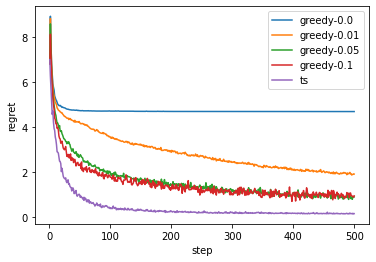

In [9]:
df_concat = pd.concat(results)
plt_df = df_concat.groupby(['agent', 'step']).agg({'regret':np.mean}).reset_index()
fig, ax = plt.subplots()

for agent_type in agent_types:
    data = plt_df.loc[plt_df['agent'] == agent_type]
    ax.plot(data['step'], data['regret'], label=agent_type)

ax.set_xlabel('step')
ax.set_ylabel('regret')
ax.legend()
plt.show()

# Appendix

## 로그정규분포의 확률밀도함수

로그정규분포의 확률밀도함수를 도출하는 것은 $X\sim N(\mu,\sigma^2)$일 때 $Y=\text{exp}(X)$의 확률밀도함수를 도출하는 것이다. $f(x)=\text{exp}(x)$가 단조증가함수이므로 아래와 같은 전개가 성립한다.
$$
P(Y\leq y)=P(\text{exp}(X)\leq y)=P(X\leq\ln y)=F_X(\ln y)
$$

누적분포함수와 확률밀도함수와의 관계를 이용해 아래와 같은 결론을 얻는다.
$$
p_Y(y)=\frac{\mathrm{d}}{\mathrm{d}y}P(Y\leq y)=\frac{\mathrm{d}}{\mathrm{d}y}F_X(\ln y)=\frac{\mathrm{d}x}{\mathrm{d}y}\frac{\mathrm{d}}{\mathrm{d}x}F_X(\ln y)=\frac{1}{y}f_X(\ln y)
$$

따라서, $X\sim N(\mu,\sigma^2)$일 때, $Y=\text{exp}(X)$의 확률밀도함수는 아래와 같다.
$$
\therefore p_Y(y)=\frac{1}{y\sqrt{2\pi\sigma^2}}\text{exp}\left(-\frac{(\ln y-\mu)^2}{2\sigma^2}\right),\;\;y>0
$$

## 로그정규분포의 기대값

위와 같은 확률밀도함수를 갖는 확률변수 $Y$의 평균을 계산해본다. 참고로 $X=\ln Y$라고 하면 $\frac{\mathrm{d}y}{\mathrm{d}x}=\text{exp}(x)$이다(즉, $\mathrm{d}y=\text{exp}(x)\mathrm{d}x$)

$$
\mathbb{E}[Y]=\int_0^\infty\frac{y}{y\sqrt{2\pi\sigma^2}}\text{exp}\left(-\frac{(\ln y-\mu)^2}{2\sigma^2}\right)\mathrm{d}y=\int_{-\infty}^{\infty}\frac{1}{\sqrt{2\pi\sigma^2}}\text{exp}\left(-\frac{(x-\mu)^2}{2\sigma^2}+x\right)\mathrm{d}x
$$

지수부 안을 정리하고, 평균과 분산이 각각 $(\mu-\sigma^2, \sigma^2)$인 정규분포의 성질을 활용하면 아래와 같은 결론을 얻는다.

$$
\mathbb{E}[Y]=\text{exp}\left(\mu+\frac{\sigma^2}{2}\right)\int_{-\infty}^\infty\frac{1}{\sqrt{2\pi\sigma^2}}\text{exp}\left(-\frac{(x-\mu+\sigma^2)^2}{2\sigma^2}\right)\mathrm{d}x=\text{exp}\left(\mu+\frac{\sigma^2}{2}\right)
$$

이를 통해, 위 예시에서와 같이 평균과 분산이 각각 $(\ln\theta-\frac{\widetilde{\sigma}^2}{2}, \widetilde{\sigma}^2)$인 정규분포로부터 로그 정규분포를 도출하면 그 로그 정규분포의 평균은 $\text{exp}\left(\ln\theta-\frac{\widetilde{\sigma}^2}{2}+\frac{\widetilde{\sigma}^2}{2}\right)=\theta$가 됨을 알 수 있다.

## $\theta$에 대한 믿음 업데이트하기

$t$번째 step에서 노드 $m$에서 노드 $n$으로 향하는 edge를 통과하는 데 걸린 시간이 $y_{m,n,t}$로 측정되었을 때, 이 값을 바탕으로 이 edge를 통과하는 데 걸리는 시간의 기대값인 $\theta_{m,n}$에 대한 믿음을 업데이트할 수 있다. 즉, 위에서 정의한 $\theta_{m,n}$와 $y_{m,n,t}|\theta_{m,n}$의 분포를 바탕으로 $\theta_{m,n}|y_{m,n,t}$의 분포를 도출한다(편의상 아랫첨자는 생략한다). 먼저, 베이즈 정리에 따라,

$$
p(\theta|y)\propto p(y|\theta)p(\theta)\equiv\ln p(\theta|y)\propto \ln p(y|\theta) + \ln p(\theta)
$$

인데, 위에서 정의한 바에 따르면

$$
\ln p(y|\theta)=-\ln y-\frac{1}{2}\ln 2\pi - \frac{1}{2}\ln\widetilde{\sigma}^2-\frac{(\ln y-\ln\theta+\frac{\widetilde{\sigma}^2}{2})^2}{2\widetilde{\sigma}^2},\;\;\ln p(\theta)=-\ln\theta-\frac{1}{2}\ln 2\pi-\frac{1}{2}\ln\sigma^2_0-\frac{(\ln\theta-\mu_0)^2}{2\sigma^2_0}
$$

이므로, $\ln p(y|\theta) + \ln p(\theta)$를 $\theta$에 대해 정리해서 아래와 같은 결론을 얻는다.

$$
\ln p(\theta|y)\propto -\ln\theta-\frac{(\ln\theta-\mu_0)^2}{2\sigma^2_0}-\frac{\left(\ln y-\ln\theta+\frac{\widetilde{\sigma}^2}{2}\right)^2}{2\widetilde{\sigma}^2}\;\;\cdots\;\;(1)
$$

이를 로그정규분포의 커널 형태에 맞게 정리할 수 있다. 즉,

$$
(1) \propto -\ln\theta-\left\{\frac{\{(\ln\theta)^2-2\mu_0\ln\theta+\mu^2_0\}}{2\sigma^2_0}+\frac{(\ln\theta)^2-2\left(\ln y+\frac{\widetilde{\sigma}^2}{2}\right)\ln\theta+\left(\ln y+\frac{\widetilde{\sigma}^2}{2}\right)^2}{2\widetilde{\sigma}^2}\right\}\;\;\cdots\;\;(2)
$$

(2)를 $\theta$에 대해 더 정리하면,

$$
(2)\propto-\ln\theta-\left\{\frac{1}{2}\left(\frac{1}{\sigma^2_0}+\frac{1}{\widetilde{\sigma}^2}\right)(\ln\theta)^2-\left(\frac{\mu_0}{\sigma^2_0}+\frac{\ln y}{\widetilde{\sigma}^2}+\frac{1}{2}\right)\ln\theta\right\}\propto-\ln\theta-\frac{\left\{\ln\theta-\frac{\left(\frac{\mu_0}{\sigma^2_0}+\frac{\ln y}{\widetilde{\sigma}^2}+\frac{1}{2}\right)}{\left(\frac{1}{\sigma^2_0}+\frac{1}{\widetilde{\sigma}^2}\right)}\right\}^2}{2\left(1/\left(\frac{1}{\sigma^2_0}+\frac{1}{\widetilde{\sigma}^2}\right)\right)}
$$

이므로, 아래와 같은 결론을 얻는다.

$$
\theta|y\sim LN\left(\frac{\left(\frac{\mu_0}{\sigma^2_0}+\frac{\ln y}{\widetilde{\sigma}^2}+\frac{1}{2}\right)}{\left(\frac{1}{\sigma^2_0}+\frac{1}{\widetilde{\sigma}^2}\right)},\frac{1}{\left(\frac{1}{\sigma^2_0}+\frac{1}{\widetilde{\sigma}^2}\right)}\right)
$$